# Inference Session API

## Introduction

In this tutorial, you will learn how to infer deployed models in a simple and efficient way with `sly.nn.inference.Session`.
This class is a convenient wrapper for a low-level API. It under the hood is just a communication with the serving app via `requests`.

Also check the [Full tutorial of Inference Session](https://github.com/supervisely-ecosystem/tutorial-inference-session).

## 0. Preparing the notebook

### Installing supervisely

In [ ]:
%%bash
pip install supervisely
git clone https://github.com/supervisely-ecosystem/tutorial-inference-session.git

In [ ]:
cd tutorial-inference-session

### Initialize your `sly.Api`

You need to get your:
- `SERVER_ADDRESS`
- `API_TOKEN`

**See details in [Basics of authentication](https://developer.supervise.ly/getting-started/basics-of-authentication) tutorial**

In [7]:
import supervisely as sly

# Paste your data here:
server_address = "...YOUR_ADDRESS..."  # e.g: https://app.supervise.ly
api_token = "...YOUR_TOKEN..."

api = sly.Api(server_address=server_address, token=api_token)

### Deploy your model on Supervisely platform

**1. Serve the model you want (e.g. [Serve YOLOv5](https://ecosystem.supervise.ly/apps/yolov5/supervisely/serve)).** *(deploying may take some time)*

**2. Copy the `task_id` from here:**

![getting-task-id](https://user-images.githubusercontent.com/31512713/218194505-b161be1e-5a05-488b-8eb7-9bc0f24141e2.png)

**3. Paste the token_id here:**

In [8]:
task_id = ...

## 1. Connecting to the model with `sly.nn.inference.Session`

After the model has served, we can create a `Session` to connect and interact with it:

In [9]:
inference_session = sly.nn.inference.Session(api, task_id=task_id)

## 2. Get the model info

### Session info

Each app with a deployed model has its own unique task_id (or session_id which is the same), model_name, pretrained_dataset and other useful info that can be obtained with the `get_session_info()` method.

In [23]:
inference_session.get_session_info()

{'app_name': 'Serve YOLOv5',
 'session_id': 27209,
 'model_files': '/sly-app-data/model/yolov5s.pt',
 'number_of_classes': 80,
 'sliding_window_support': 'advanced',
 'videos_support': True,
 'async_video_inference_support': True,
 'task type': 'object detection',
 'model_name': 'YOLOv5',
 'checkpoint_name': 'yolov5s',
 'pretrained_on_dataset': 'COCO train 2017',
 'device': 'cuda',
 'half': 'True',
 'input_size': 640}

### Project meta of the model

The model may be pretrained on various datasets, like a COCO, ImageNet or even your custom data. The datasets are different in classes/tags they have. Therefore each dataset has its own meta information called `project_meta` in Supervisely. To get the `project_meta` of the dataset the model was pretrained on, use the method `get_model_project_meta()`.

In [27]:
model_meta = inference_session.get_model_project_meta()
print("The first 10 classes of model_meta:")
[cls.name for cls in model_meta.obj_classes][:10]

The first 10 classes of model_meta:


['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light']

The `model_meta` will be used later, when we will visualize model predictions.

## 3. Set the inference settings

Each model has its own inference settings, like a `conf_thres`, `iou_thres` and others. You can get the full list of supported settings with `get_default_inference_settings()`:

**Get default settings:**

In [29]:
default_settings = inference_session.get_default_inference_settings()
default_settings

{'conf_thres': 0.25,
 'iou_thres': 0.45,
 'augment': False,
 'debug_visualization': False}

There are **3 ways** to set the inference settings:
- `update_inference_settings(**kwargs)`
- `set_inference_settings(dict)`
- `set_inference_settings(YAML)`
- earlier at creating the `Session`

**a) Update only the parameters you want:**

In [31]:
inference_session.update_inference_settings(conf_thres=0.4, iou_thres=0.55)
inference_session.inference_settings

{'conf_thres': 0.4, 'iou_thres': 0.55}

**b) Set parameters with a dict:**

In [37]:
settings = {
    "conf_thres": 0.25
}
inference_session.set_inference_settings(settings)
inference_session.inference_settings

{'conf_thres': 0.25}

**c) Set parameters with a YAML file:**

In [10]:
inference_session.set_inference_settings("settings.yml")
inference_session.inference_settings

{'conf_thres': 0.55, 'augment': False}

## 4. Image Inference

**There are several ways how to infer an image:**

- by Supervisely ID
- by local path
- by URL from the web
- batch of IDs
- batch of paths

In [14]:
image_path = "img/image_01.jpg"
pred = inference_session.inference_image_path(image_path)
pred

{'annotation': {'description': '',
  'size': {'height': 1600, 'width': 1280},
  'tags': [],
  'objects': [{'classTitle': 'person',
    'description': '',
    'tags': [{'name': 'confidence', 'value': 0.869140625}],
    'points': {'exterior': [[764, 272], [1062, 1002]], 'interior': []},
    'geometryType': 'rectangle',
    'shape': 'rectangle'},
   {'classTitle': 'horse',
    'description': '',
    'tags': [{'name': 'confidence', 'value': 0.87109375}],
    'points': {'exterior': [[393, 412], [1274, 1435]], 'interior': []},
    'geometryType': 'rectangle',
    'shape': 'rectangle'}],
  'customBigData': {}},
 'data': {}}

The prediction is a `dict` with two fields:

- `"annotation"`: contains a predicted annotation, that can be easily converted to `sly.Annotation`.
- `"data"`: additional metadata of the prediction. In most cases you won't need this.

**Converting to `sly.Annotation` format:**

In [16]:
model_project_meta = inference_session.get_model_project_meta()
predicted_annotation = sly.Annotation.from_json(pred["annotation"], project_meta=model_project_meta)

**Note:** since the prediction contains only class name and coordinates of rectangle for each object, which is not enough to interpret the annotation in Supervisely format correctly, we need to pass the `model_project_meta` too.

### Visualize model prediction

The code below shows how we can visualize the model predictions:

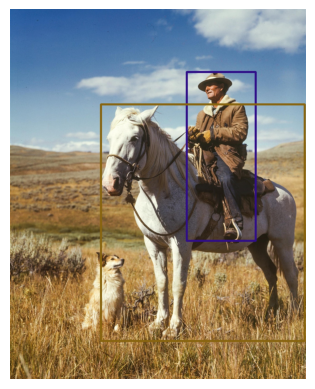

In [17]:
# Inference
image_path = "img/image_01.jpg"
pred = inference_session.inference_image_path(image_path)

# Convert to sly.Annotation
predicted_annotation = sly.Annotation.from_json(pred["annotation"], model_project_meta)

# Read the image that was inferred
image_np = sly.image.read(image_path)

# Draw the pred annotation and save it to disk
save_path_predicted = "image_01_pred.jpg"
predicted_annotation.draw_pretty(bitmap=image_np, output_path=save_path_predicted, fill_rectangles=False, thickness=7)

# Show
from matplotlib import pyplot as plt
image_pred = sly.image.read(save_path_predicted)
plt.imshow(image_pred)
plt.axis('off');

### Upload prediction to dataset in Supervisely

**Now you can upload the image with predictions to the Supervisely platform**

**Get your `workspace_id`:**

In [ ]:
workspace_id = ...

In [20]:
# Create new project and dataset
project_info = api.project.create(workspace_id, "My model predictions", change_name_if_conflict=True)
dataset_info = api.dataset.create(project_info.id, "First dataset")

# Update project meta with model's classes
api.project.update_meta(project_info.id, model_project_meta)
project_meta = api.project.get_meta(project_info.id)
project_meta = sly.ProjectMeta.from_json(project_meta)

# Upload the image
image_name = os.path.basename(image_path)
img_info = api.image.upload_path(dataset_info.id, name=image_name, path=image_path)

# Upload model predictions to Supervisely
# Here we need to update predicted_annotation with a new project_meta obtained from the server:
predicted_annotation = sly.Annotation.from_json(pred['annotation'], project_meta)
api.annotation.upload_ann(img_info.id, predicted_annotation)

**Note:** when you update the `project_meta`, you need to get a newly generated `project_meta` back, because there will be new ids assigned to the classes and tags.

**Check the result on the Supervisely platform:**

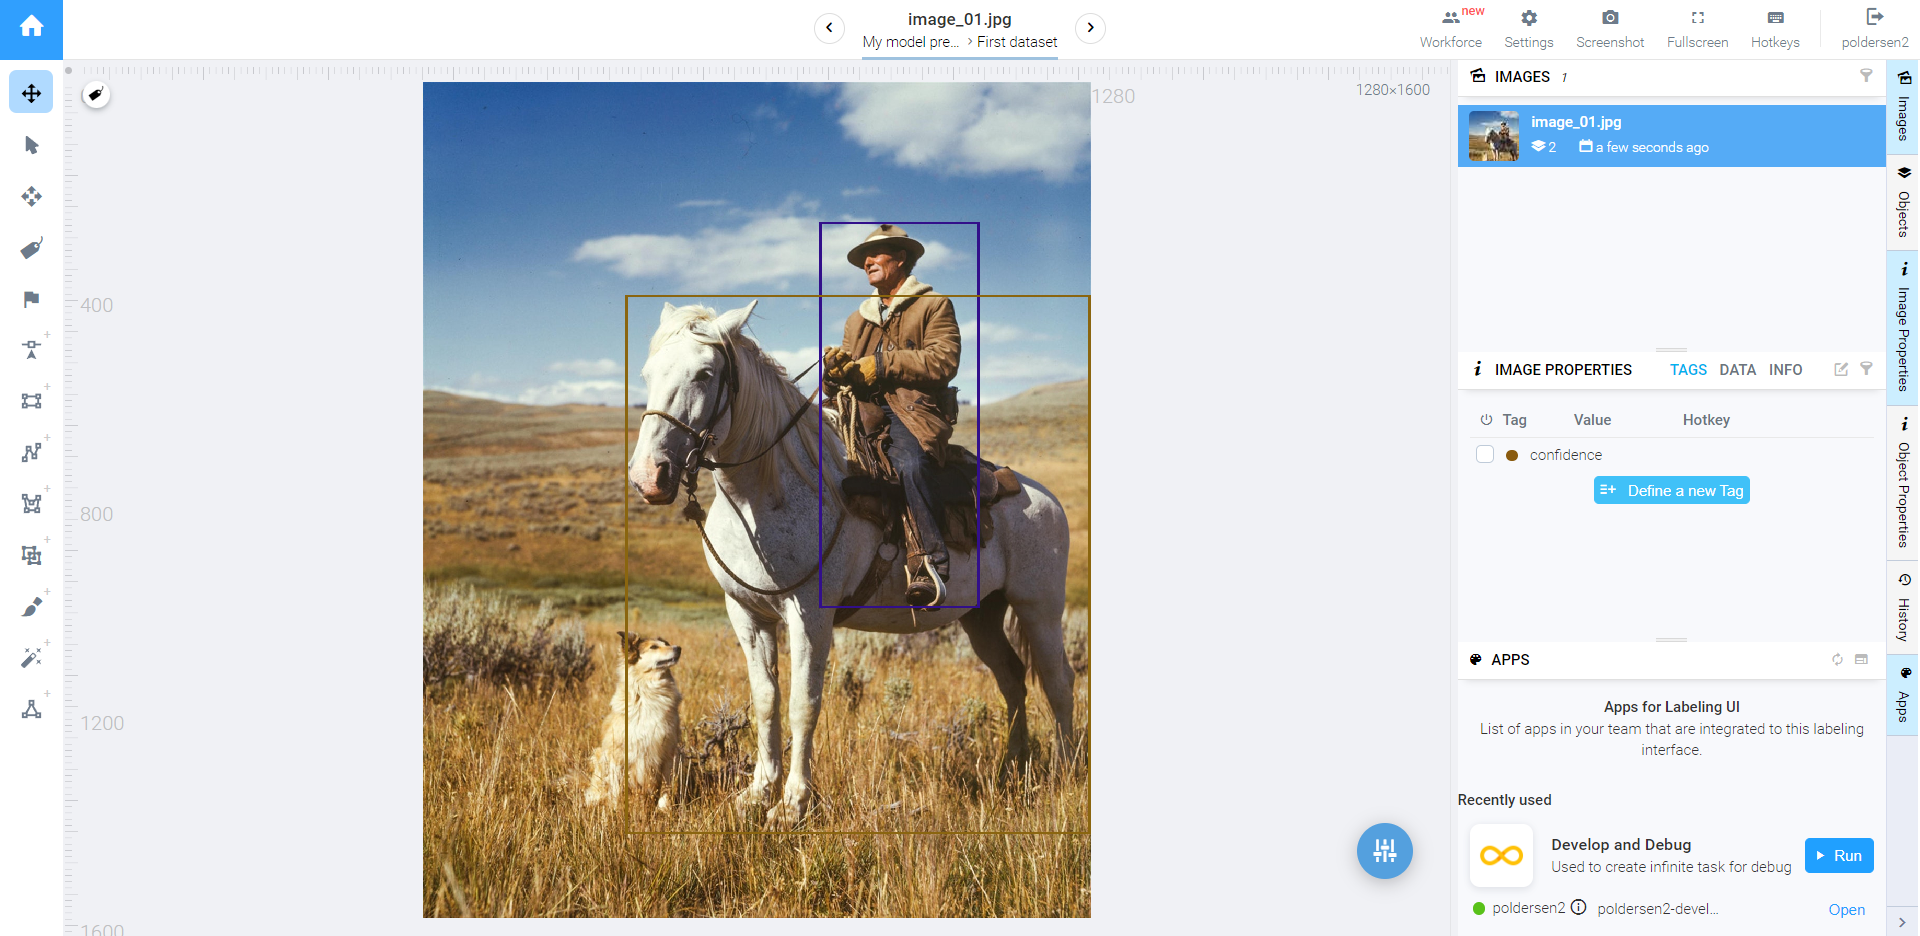

## 5. Video Inference

**First upload a video to the Supervisely and paste it here:**

In [ ]:
video_id = ...

### Method 1. Inferring video with iterator

**The video inference is simple too.**

The first way is to infer the video with `inference_video_id_async` method. It returns an iterator, which can be useful in processing predictions frame by frame. As soon as the model done with a one frame it will be yielded by the iterator:

In [26]:
from tqdm import tqdm

pred_frames = []
for frame_ann in tqdm(inference_session.inference_video_id_async(video_id)):
    pred_frames.append(frame_ann)

{"message": "The video is preparing on the server, this may take a while...", "timestamp": "2023-02-13T23:19:36.379Z", "level": "info"}
{"message": "Inference has started:", "progress": {"current": 0, "total": 10}, "is_inferring": true, "cancel_inference": false, "result": null, "pending_results": [], "timestamp": "2023-02-13T23:19:42.910Z", "level": "info"}
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.80s/it]


There are some parameters can be passed to the video inference:

- `start_frame_index`: the first frame to start
- `frames_count`: total frames to infer
- `frames_direction`: video playback direction, either "forward" or "backward"

#### Getting more information about the inference process:

In [27]:
frame_iterator = inference_session.inference_video_id_async(video_id)
total_frames = len(frame_iterator)
for i, frame_ann in enumerate(frame_iterator):
    labels = sly.Annotation.from_json(frame_ann['annotation'], model_project_meta).labels
    predicted_classes = [x.obj_class.name for x in labels]
    print(f"Frame {i+1}/{total_frames} done. Predicted classes = {predicted_classes}")

{"message": "The video is preparing on the server, this may take a while...", "timestamp": "2023-02-13T23:20:15.796Z", "level": "info"}
{"message": "Inference has started:", "progress": {"current": 0, "total": 10}, "is_inferring": true, "cancel_inference": false, "result": null, "pending_results": [], "timestamp": "2023-02-13T23:20:26.617Z", "level": "info"}


Frame 1/10 done. Predicted classes = ['car']
Frame 2/10 done. Predicted classes = ['car', 'car']
Frame 3/10 done. Predicted classes = ['car', 'car']
Frame 4/10 done. Predicted classes = ['car', 'car']
Frame 5/10 done. Predicted classes = ['car', 'car']
Frame 6/10 done. Predicted classes = ['car']
Frame 7/10 done. Predicted classes = ['car', 'car']
Frame 8/10 done. Predicted classes = ['car', 'car']
Frame 9/10 done. Predicted classes = ['car']
Frame 10/10 done. Predicted classes = ['car']


#### Stop async video inference with

If you need to stop the inference, use `inference_session.stop_async_inference()`:

In [28]:
from tqdm import tqdm

video_id = 18635803

for i, frame_ann in enumerate(tqdm(inference_session.inference_video_id_async(video_id))):
    if i == 2:
        inference_session.stop_async_inference()

{"message": "The video is preparing on the server, this may take a while...", "timestamp": "2023-02-13T23:20:46.067Z", "level": "info"}
{"message": "Inference has started:", "progress": {"current": 0, "total": 10}, "is_inferring": true, "cancel_inference": false, "result": null, "pending_results": [], "timestamp": "2023-02-13T23:20:55.936Z", "level": "info"}
 30%|████████████████████████▉                                                          | 3/10 [00:04<00:11,  1.58s/it]


### Method 2. Inferring video without iterator

If you don't need to iterate every frame, you can use the `inference_video_id` method:

In [29]:
video_id = 18635803

predictions_list = inference_session.inference_video_id(
    video_id, start_frame_index=5, frames_count=15, frames_direction="forward"
)

**Note:** it is recommended to use this method for very small videos, because the code will wait until the whole video has been inferred and you even can't to track the progress.